# Bank Customer Churn Prediction 

- <a href='#1'>1. Load Data</a>
- <a href='#2'>2. Data Manipulation</a>
- <a href='#3'>3. Exploratory Data Analysis</a>
    - <a href='#3.1'>3.1. Customer Churn Features</a>
    - <a href='#3.2'>3.2. Categorical Variables Distribution</a>
    - <a href='#3.3'>3.3. Continuous Variables Distirbution</a>
    - <a href='#3.4'>3.4. Finding missing values</a>
    - <a href='#3.5'>3.5. Correlation</a>
    - <a href='#3.6'>3.6. Detecting and Handling Outliers</a>
- <a href='#4'>4. Data preparation for ML</a>
    - <a href='#4.1'>4.1. Applying Normalization</a>
    - <a href='#4.2'>4.2. Applying Upsampling</a>
    - <a href='#4.3'>4.3. Applying Downsampling</a>
- <a href='#5'>5. Machine Learning Models</a>
    - <a href='#5.1'>5.1. Splitting the Data</a>
    - <a href='#5.1'>5.2. Class Weight Adjustment</a>
    - <a href='#5.3'>5.3. Feature Importances</a>
- <a href='#6'>6. Train and build baseline model</a>
    - <a href='#6.1'>6.1. Logistic Regression</a>
    - <a href='#6.2'>6.2. Random Forest</a>
    - <a href='#6.3'>6.3. KNeighbors Classifier</a>
    - <a href='#6.4'>6.4. AdaBoost</a>
    - <a href='#6.5'>6.5. Gradient Boosting</a>    
- <a href='#7'>7. Testing the baseline model</a> 
    - <a href='#7.1'>7.1. ROC-AUC performance of the models</a>
- <a href='#8'>8. Optimization using Cross-Validation and Hyperparameter Tuning</a>
        - <a href='#8.1'>8.1. Implementing a cross-validation based approach</a>    
        - <a href='#8.2'>8.2. Implementing hyperparameter tuning </a>
- <a href='#9'>9. Conclusion</a>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import plotly.offline as py 
import plotly.graph_objs as go 
import plotly.tools as tls 
import plotly.figure_factory as ff

from imblearn.over_sampling import SMOTE

from sklearn import metrics
from sklearn.utils import resample
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree

from sklearn.utils import shuffle
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.metrics import accuracy_score, recall_score, classification_report, f1_score, roc_auc_score, roc_curve, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Load Data

In [2]:
churn_df = pd.read_csv('Churn.csv')

### Data Manipulation

In [3]:
churn_df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

We can see that the columns name are not consistent.

In [4]:
# Convert all columns heading in lowercase 
clean_column_name = []
columns = churn_df.columns
for i in range(len(columns)):
    clean_column_name.append(columns[i].lower())
churn_df.columns = clean_column_name

In [5]:
# Drop the irrelevant columns  as shown above
churn_df = churn_df.drop(["rownumber", "customerid", "surname"], axis = 1)

In [6]:
#Separating churn and non churn customers
churn     = churn_df[churn_df["exited"] == 1]
not_churn = churn_df[churn_df["exited"] == 0]

In [7]:
target_col = ["exited"]
cat_cols   = churn_df.nunique()[churn_df.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in churn_df.columns if x not in cat_cols + target_col]

## Exploratory Data Analysis (EDA)

In [8]:
churn_df.head()

creditscore geography  gender  age  tenure    balance  numofproducts  \
0          619    France  Female   42     2.0       0.00              1   
1          608     Spain  Female   41     1.0   83807.86              1   
2          502    France  Female   42     8.0  159660.80              3   
3          699    France  Female   39     1.0       0.00              2   
4          850     Spain  Female   43     2.0  125510.82              1   

   hascrcard  isactivemember  estimatedsalary  exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

In [9]:
churn_df.shape

(10000, 11)

In [10]:
churn_df.nunique()

creditscore         460
geography             3
gender                2
age                  70
tenure               11
balance            6382
numofproducts         4
hascrcard             2
isactivemember        2
estimatedsalary    9999
exited                2
dtype: int64

In [11]:
churn_df[churn_df.columns[:10]].describe()

creditscore           age       tenure        balance  numofproducts  \
count  10000.000000  10000.000000  9091.000000   10000.000000   10000.000000   
mean     650.528800     38.921800     4.997690   76485.889288       1.530200   
std       96.653299     10.487806     2.894723   62397.405202       0.581654   
min      350.000000     18.000000     0.000000       0.000000       1.000000   
25%      584.000000     32.000000     2.000000       0.000000       1.000000   
50%      652.000000     37.000000     5.000000   97198.540000       1.000000   
75%      718.000000     44.000000     7.000000  127644.240000       2.000000   
max      850.000000     92.000000    10.000000  250898.090000       4.000000   

         hascrcard  isactivemember  estimatedsalary  
count  10000.00000    10000.000000     10000.000000  
mean       0.70550        0.515100    100090.239881  
std        0.45584        0.499797     57510.492818  
min        0.00000        0.000000        11.580000  
25%        0.00000        0.000000     51002.110000  
50%        1.00000        1.000000    100193.915000  
75%        1.00000        1.000000    149388.247500  
max        1.00000        1.000000    199992.480000

In [12]:
churn_df[churn_df.columns[:10]].median()

creditscore           652.000
age                    37.000
tenure                  5.000
balance             97198.540
numofproducts           1.000
hascrcard               1.000
isactivemember          1.000
estimatedsalary    100193.915
dtype: float64

In [13]:
churn_df[churn_df.columns[:10]].mean()

creditscore           650.528800
age                    38.921800
tenure                  4.997690
balance             76485.889288
numofproducts           1.530200
hascrcard               0.705500
isactivemember          0.515100
estimatedsalary    100090.239881
dtype: float64

### Customer Churn Features

In [14]:
percentage_labels = churn_df['exited'].value_counts(normalize = True) * 100
percentage_labels

0    79.63
1    20.37
Name: exited, dtype: float64

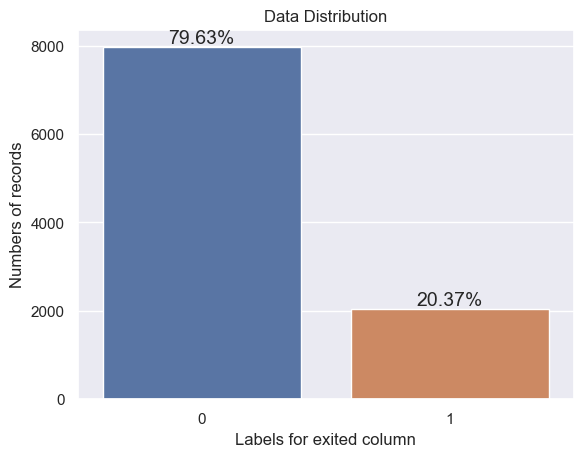

In [15]:
total_len = len(churn_df['exited'])
sns.set()
sns.countplot(churn_df.exited).set_title('Data Distribution')
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 2,
            '{:.2f}%'.format(100 * (height/total_len)),
            fontsize=14, ha='center', va='bottom')
sns.set(font_scale=1.5)
ax.set_xlabel("Labels for exited column")
ax.set_ylabel("Numbers of records")
plt.show()

* Observations:
* Based on the chart above, there are many observations with the target label "0" with 80% and fewer observations with the target label "1" with 20%. This means that the column is imbalanced.

### Categorical Variables Distribution

In [16]:
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution in customer churn ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)

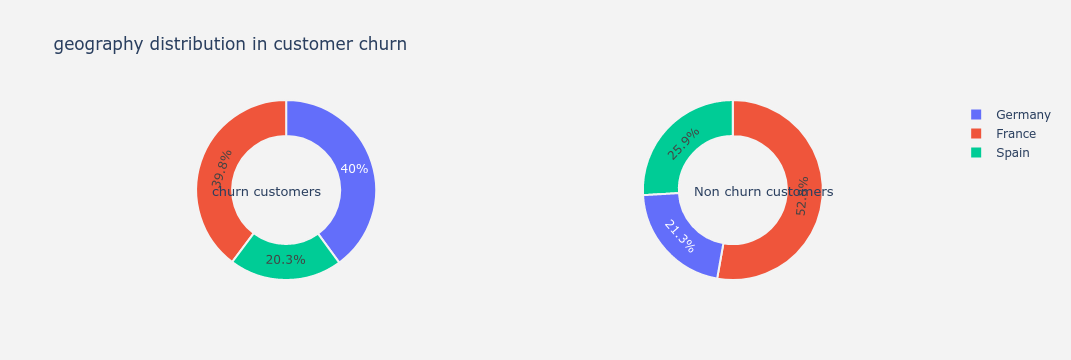

In [17]:
plot_pie(cat_cols[0])

The output above shows us that the among the churned customers those who are are geographycally located in Germay have a high rate of churn with $40\%$, followed by France with $39.8\%$ and Spain with $20.3\%$. For non chun customers France is leading with $52.8\%$, Spain with $25.9\%$ and Germany with $21.3\%$.

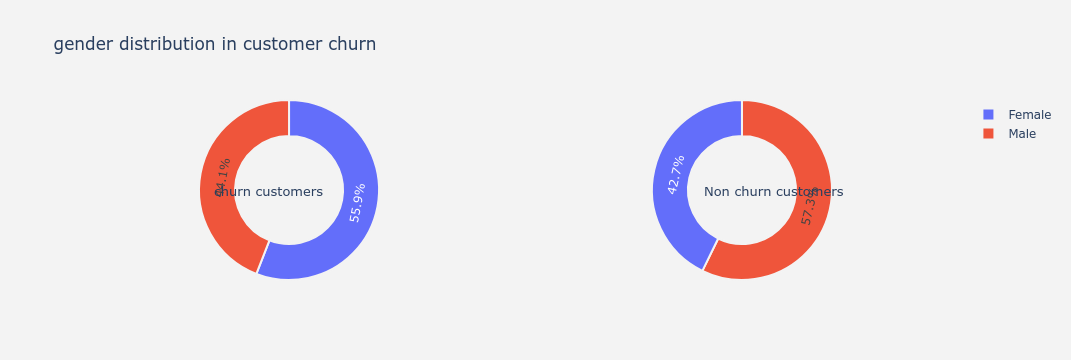

In [18]:
plot_pie(cat_cols[1])

The output above shows us that for the churn customers female have $55.9\%$, whereas male with $44.1\%$. For the case of non churn customers $57.3\%$ are male and $42.7\%$ are female.

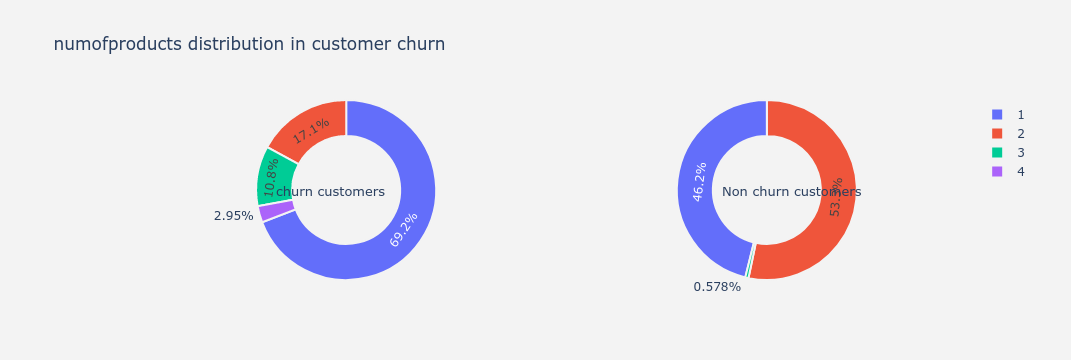

In [19]:
plot_pie(cat_cols[2])

The graph above shows that among the churn customers, the rate of those who use one product is very high with $69.2\%$, followed by  those who use two products with $17.1\%$, three products with $10.8\%$, and four products with $2.95\%$. For non churn customers, customers with two products are $53.3\%$, one product are $46.2\%$, and three products are $0.58\%$.

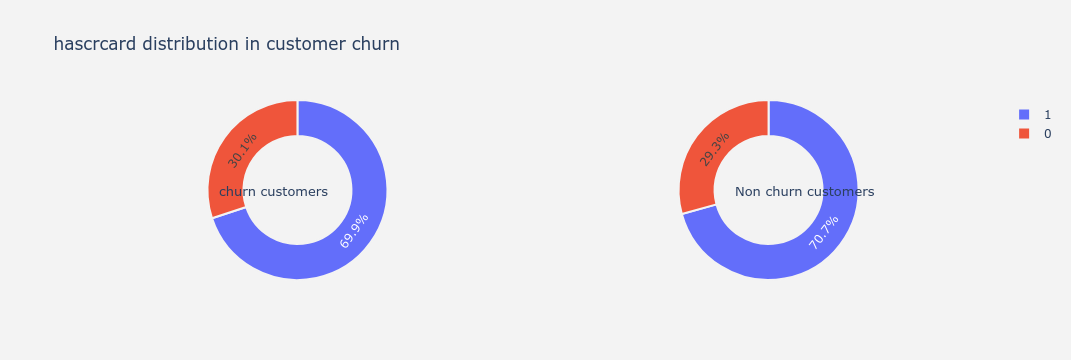

In [20]:
plot_pie(cat_cols[3])

The output above shows us that for the churn customers those who possess a card are $69.9\%$, whereas those don't possess are $30.1\%$. For the case of non churn customers $70.7\%$ possess a card and $29.3\%$ don't possess a card.

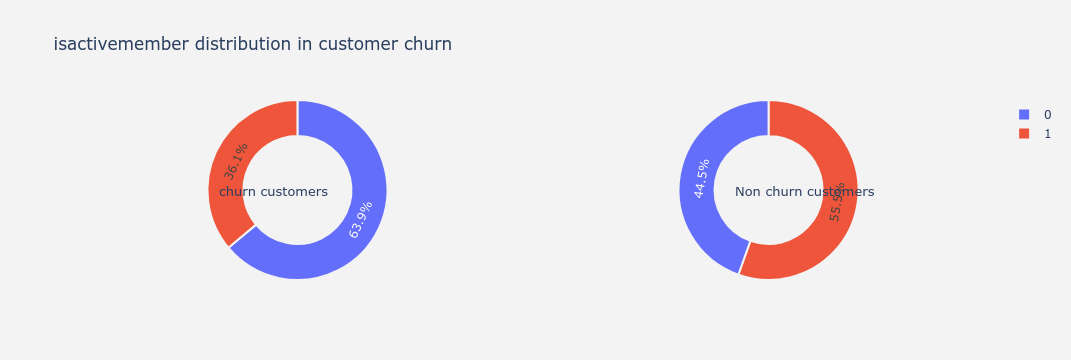

In [21]:
plot_pie(cat_cols[4])

The output above shows us that the among the churned customers those who are not active members have a high rate of churn with $63.9\%$, and active members with $36.1\%$. For non chun customers active members are leading with $55.5\%$, and non active members with $44.5\%$.

### Continuous Variables Distribution

In [22]:
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)

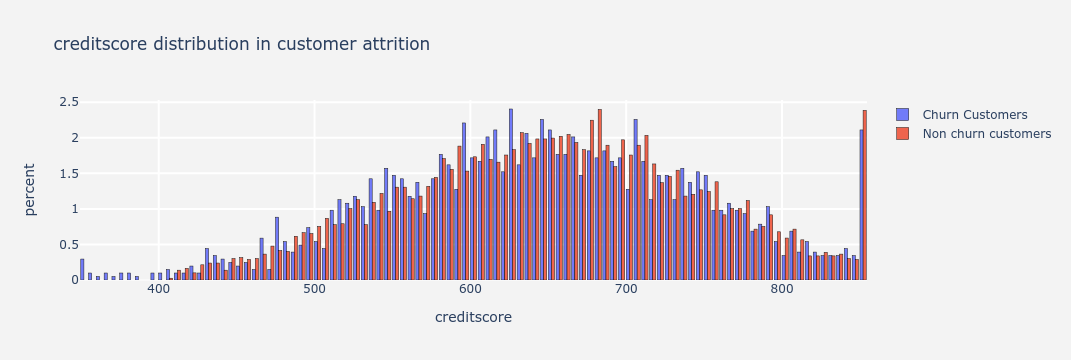

In [23]:
histogram(num_cols[0])

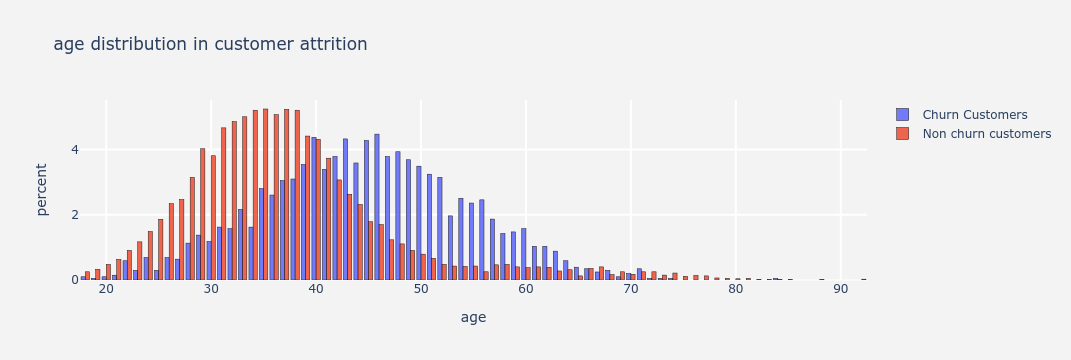

In [24]:
histogram(num_cols[1])

The graph above shows us that the customers with age of 46 are the most churned.

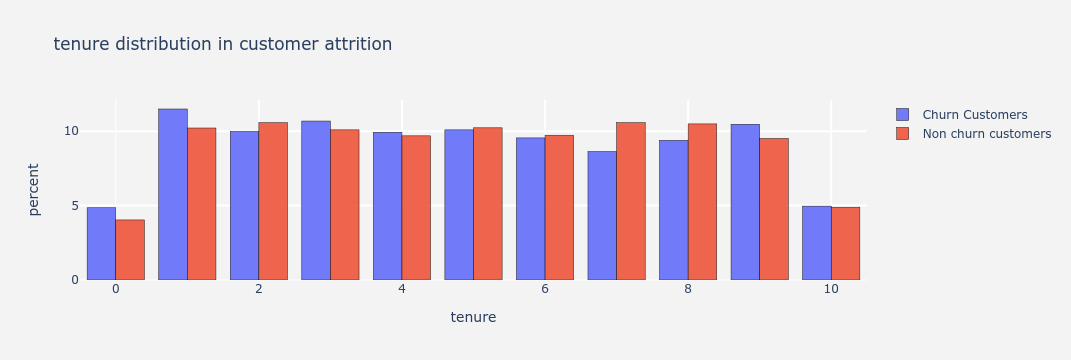

In [25]:
histogram(num_cols[2])

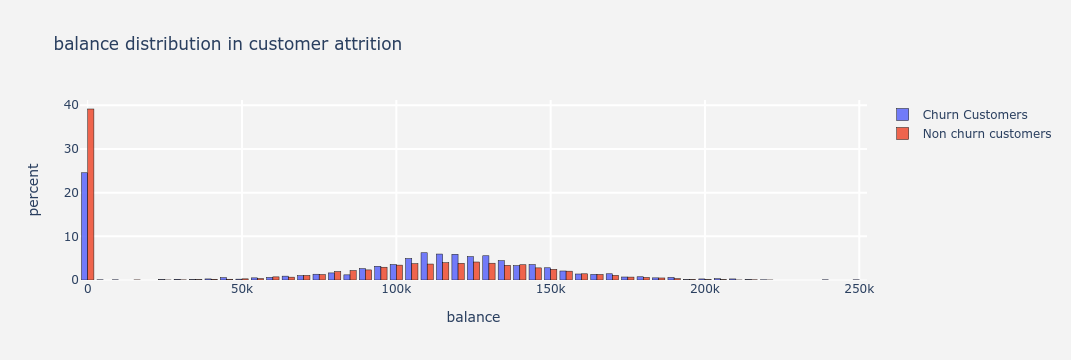

In [26]:
histogram(num_cols[3])

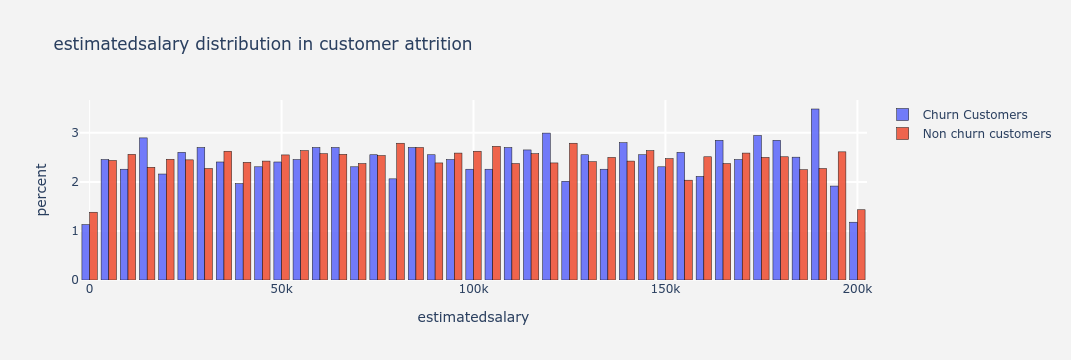

In [27]:
histogram(num_cols[4])

### Finding Missing Values and Cardinality

In [28]:
def missing_values(data):
  df = pd.DataFrame()
  for col in list(data):
    unique_values = data[col].unique()
    try:
      unique_values = np.sort(unique_values)
    except:
      pass
    nans = round(pd.isna(data[col]).sum()/data.shape[0]*100, 1)
    zeros = round((data[col] == 0).sum()/data.shape[0]*100, 1)

    df = df.append(pd.DataFrame([col, len(unique_values), nans,  zeros]).T, ignore_index = True)
  return df.rename(columns = {0: 'variable',
1: 'Unique values',
2: 'Nan %',
3: 'zeros %',
4: 'empty'}).sort_values('Nan %', ascending=False)

missing_values(churn_df)

variable Unique values Nan % zeros %
4            tenure            12   9.1     3.8
0       creditscore           460   0.0     0.0
1         geography             3   0.0     0.0
2            gender             2   0.0     0.0
3               age            70   0.0     0.0
5           balance          6382   0.0    36.2
6     numofproducts             4   0.0     0.0
7         hascrcard             2   0.0    29.4
8    isactivemember             2   0.0    48.5
9   estimatedsalary          9999   0.0     0.0
10           exited             2   0.0    79.6

In [29]:
churn_df.isna().sum()

creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

In [30]:
churn_df['tenure'] = churn_df['tenure'].fillna(0)

In [31]:
churn_df.isna().sum()

creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

* Observation:
* The column tenure is the only column with missing values with 9%. The missing values in this column are filled in with 0.
* Estimated salary and balance have high cardinality which means they have the highest number of unique values. As to categorical columns, there is low cardinality which is good when processing for ML.

### Correlation

In [32]:
# Get the correlation matrix of the training dataset
corr = churn_df.corr()
corr

creditscore       age    tenure   balance  numofproducts  \
creditscore         1.000000 -0.003965  0.003087  0.006268       0.012238   
age                -0.003965  1.000000 -0.007368  0.028308      -0.030680   
tenure              0.003087 -0.007368  1.000000 -0.005821       0.010106   
balance             0.006268  0.028308 -0.005821  1.000000      -0.304180   
numofproducts       0.012238 -0.030680  0.010106 -0.304180       1.000000   
hascrcard          -0.005458 -0.011721  0.021387 -0.014858       0.003183   
isactivemember      0.025651  0.085472 -0.025856 -0.010084       0.009612   
estimatedsalary    -0.001384 -0.007201  0.011225  0.012797       0.014204   
exited             -0.027094  0.285323 -0.013319  0.118533      -0.047820   

                 hascrcard  isactivemember  estimatedsalary    exited  
creditscore      -0.005458        0.025651        -0.001384 -0.027094  
age              -0.011721        0.085472        -0.007201  0.285323  
tenure            0.021387       -0.025856         0.011225 -0.013319  
balance          -0.014858       -0.010084         0.012797  0.118533  
numofproducts     0.003183        0.009612         0.014204 -0.047820  
hascrcard         1.000000       -0.011866        -0.009933 -0.007138  
isactivemember   -0.011866        1.000000        -0.011421 -0.156128  
estimatedsalary  -0.009933       -0.011421         1.000000  0.012097  
exited           -0.007138       -0.156128         0.012097  1.000000

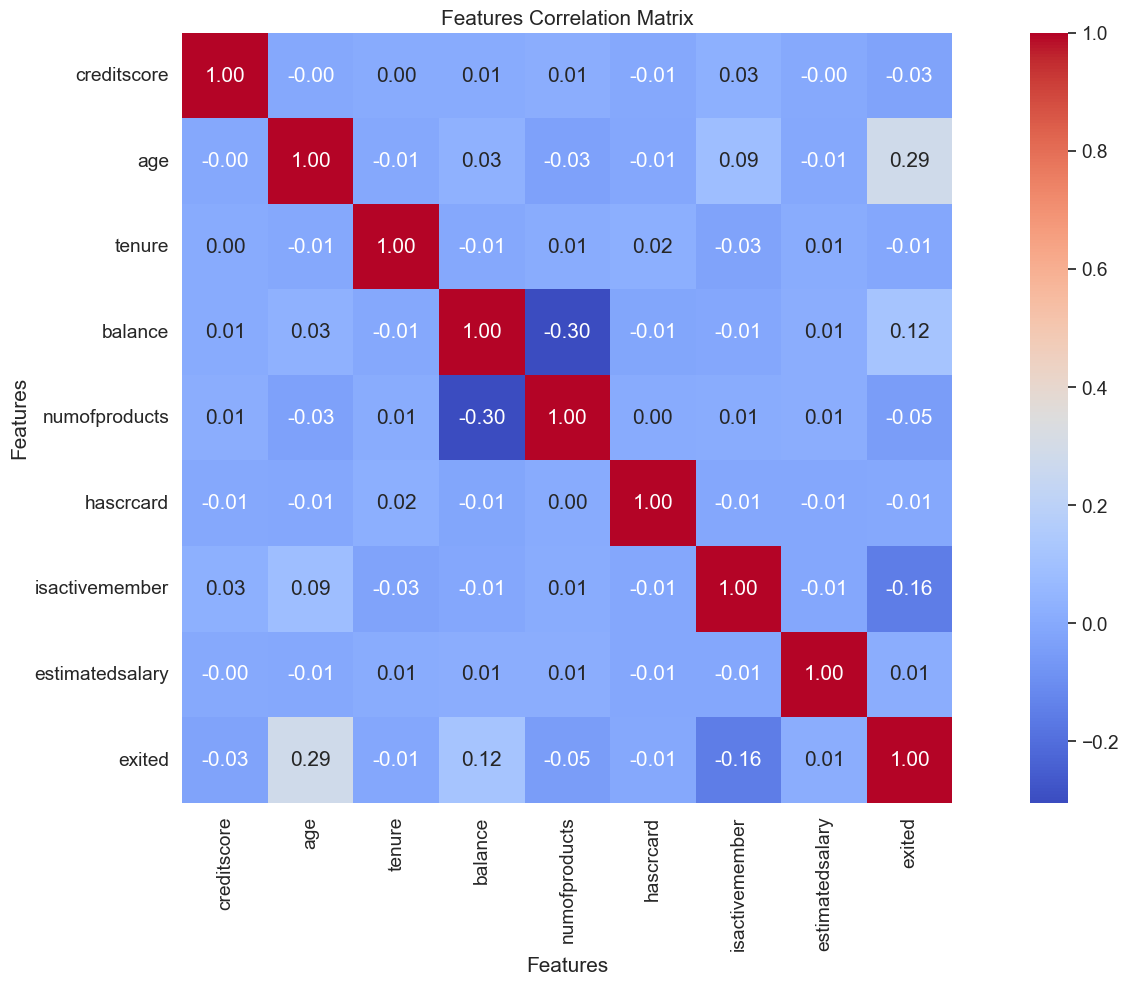

In [33]:
plt.figure(figsize=(20,10))
sns.set()
sns.set(font_scale = 1.25)
sns.heatmap(corr, annot = True, fmt = ".2f", cmap='coolwarm', square=True)
plt.title("Features Correlation Matrix")
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

* Observations:
* Cells with 1.0 values are highly correlated with each other.
* Each attribute has a very high correlation with itself, so all the diagonal values are 1.0.
* The balance attribute is negatively correlated with numberofproducts attribute. It means one attribute increases as the other decreases, and vice versa.

### Categorical Variables Distribution

In [34]:
churn_df.dtypes

creditscore          int64
geography           object
gender              object
age                  int64
tenure             float64
balance            float64
numofproducts        int64
hascrcard            int64
isactivemember       int64
estimatedsalary    float64
exited               int64
dtype: object

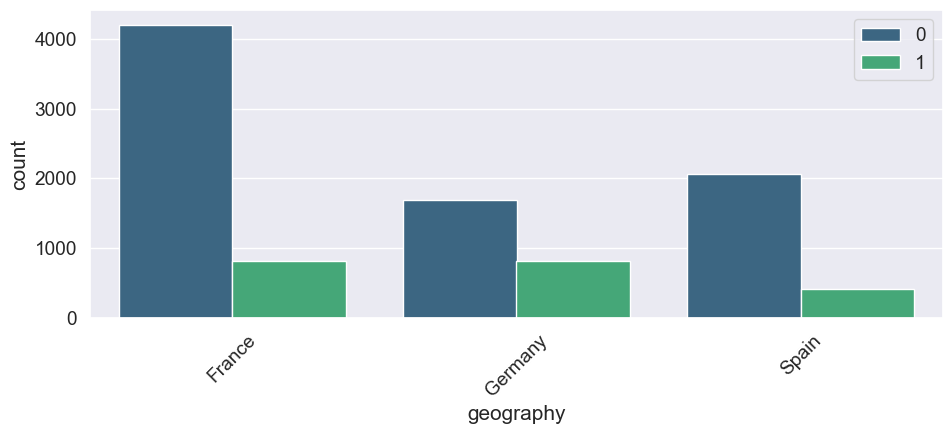

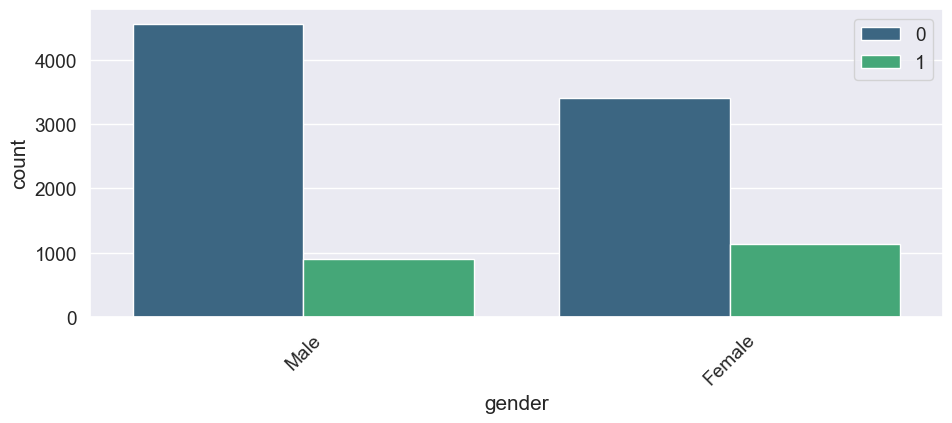

In [35]:
cat_var = ['geography', 'gender']
for i in cat_var:
    fig_dims = (11,4)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.countplot(x=i, hue='exited', ax=ax, data=churn_df, palette='viridis', order=churn_df[i].value_counts().index)
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')
    plt.show()

### Detecting and Handling Outliers

In [36]:
churn_df.describe()

creditscore           age        tenure        balance  numofproducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      4.543400   76485.889288       1.530200   
std       96.653299     10.487806      3.111573   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      2.000000       0.000000       1.000000   
50%      652.000000     37.000000      4.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

         hascrcard  isactivemember  estimatedsalary        exited  
count  10000.00000    10000.000000     10000.000000  10000.000000  
mean       0.70550        0.515100    100090.239881      0.203700  
std        0.45584        0.499797     57510.492818      0.402769  
min        0.00000        0.000000        11.580000      0.000000  
25%        0.00000        0.000000     51002.110000      0.000000  
50%        1.00000        1.000000    100193.915000      0.000000  
75%        1.00000        1.000000    149388.247500      0.000000  
max        1.00000        1.000000    199992.480000      1.000000

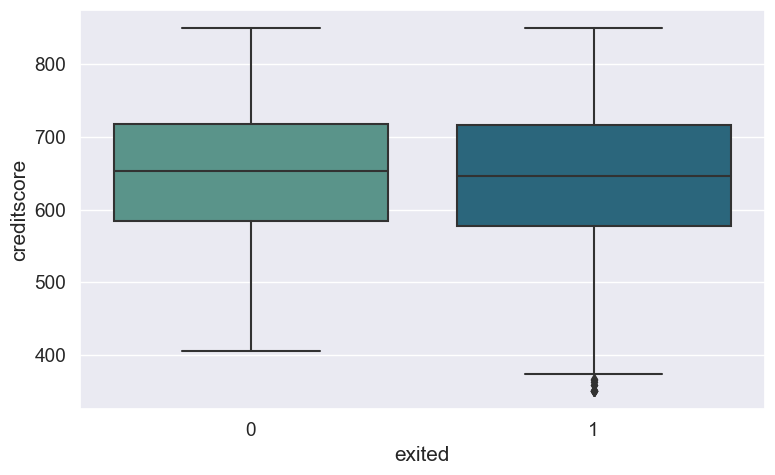

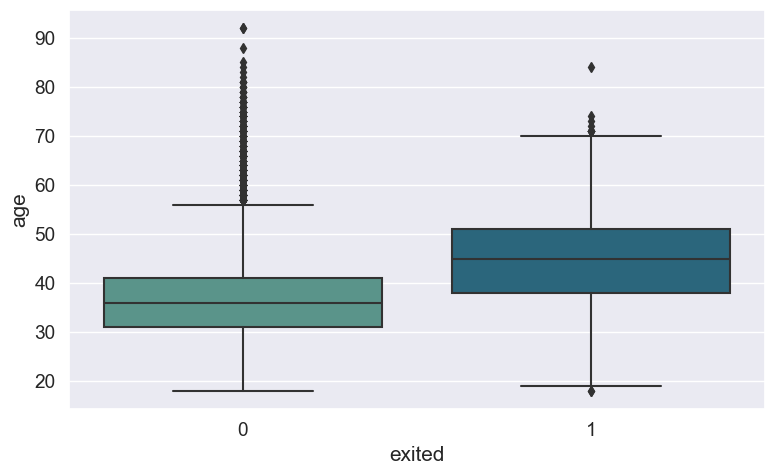

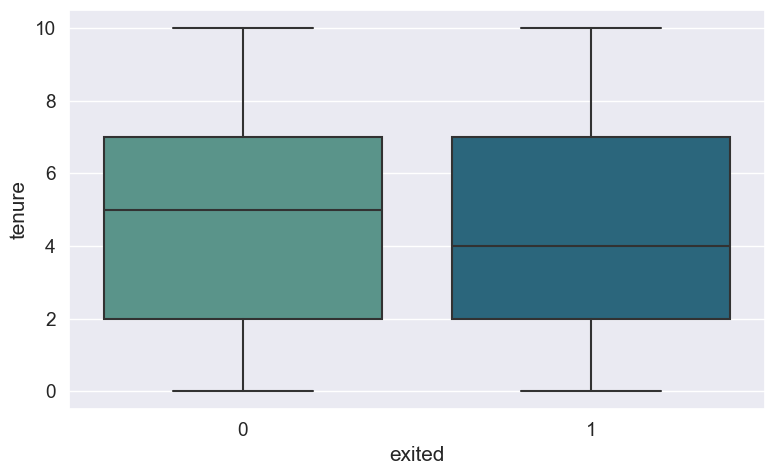

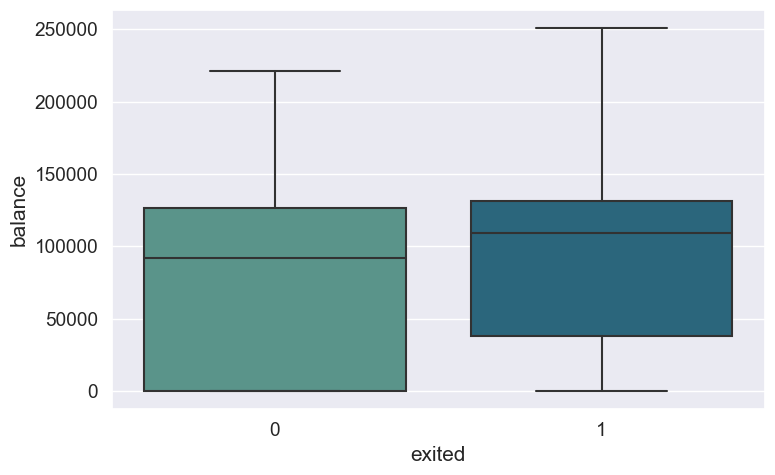

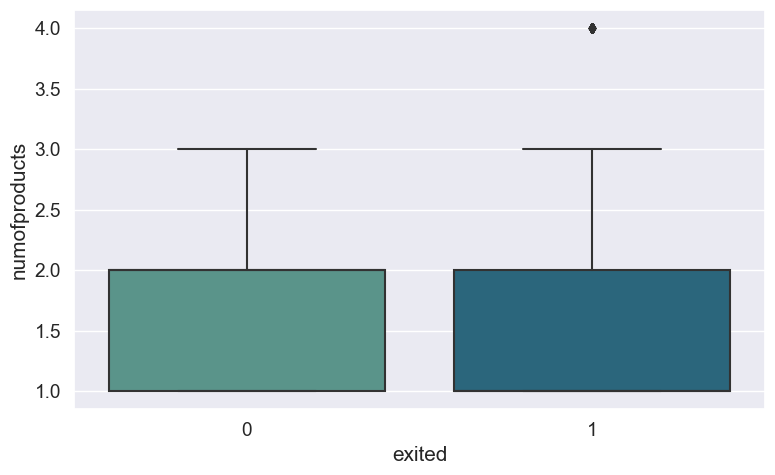

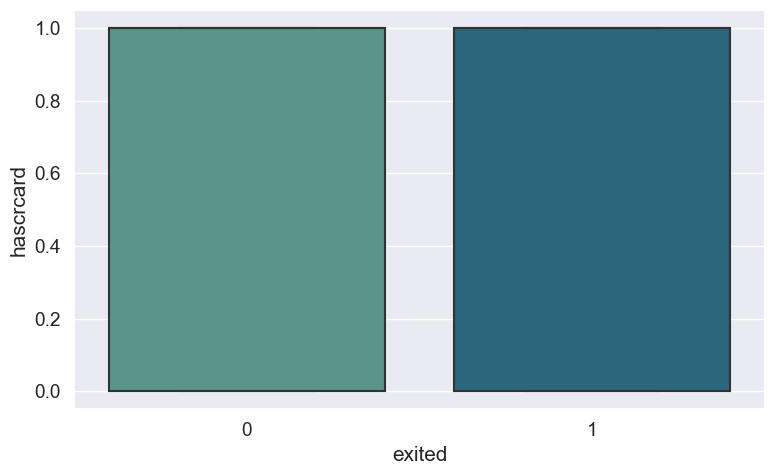

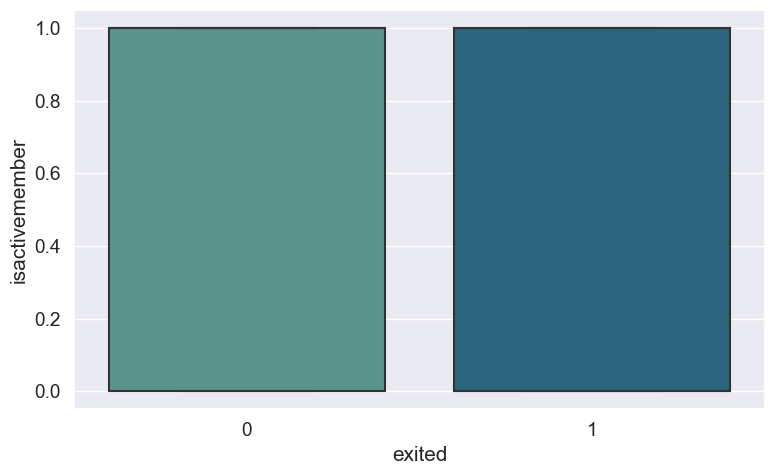

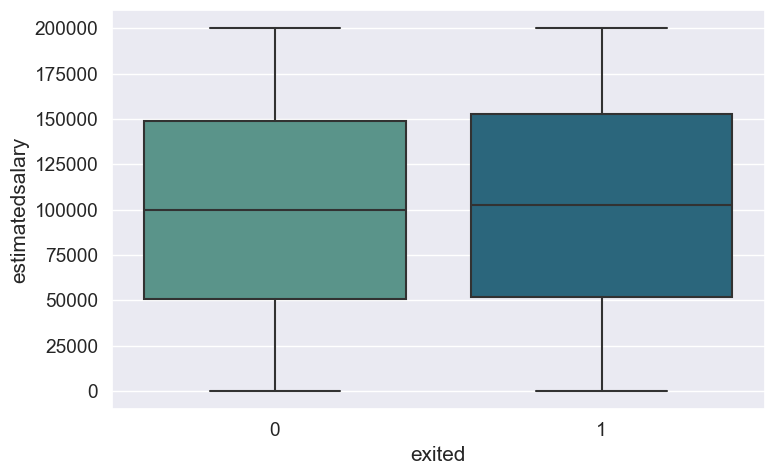

In [37]:
def boxplot(x):
    plt.figure(figsize=(8,5))
    sns.boxplot(data=churn_df, x='exited', y=churn_df[x], palette='crest')
    plt.tight_layout()
    plt.show()

feature_list = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']
for i in feature_list:
    boxplot(i)

In [38]:
#Adjusting Age to exclude 86 years old and above
age_churn = []
for val in churn_df.age:
    if val <= 85:
        age_churn.append(val)
    else:
        age_churn.append(churn_df.age.median())
        
churn_df.age = age_churn

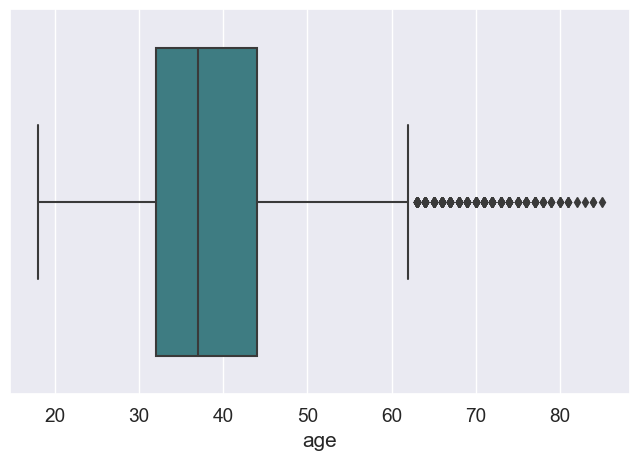

In [39]:
plt.figure(figsize=(8,5))
sns.boxplot(data=churn_df, x=churn_df.age, palette='crest')
plt.show()

* Observations:
* Age and Credit Score exhibited outliers while balance, estimated salary, and tenure shows no outliers. Age was adjusted to exlude 86 years old since they won't be able to pay back any loans they will apply to.

# Feature Engineering

In [40]:
list_category = ['geography', 'gender']
churn_df = pd.get_dummies(churn_df, columns = list_category, prefix = list_category)

In [41]:
churn_df.head()

creditscore   age  tenure    balance  numofproducts  hascrcard  \
0          619  42.0     2.0       0.00              1          1   
1          608  41.0     1.0   83807.86              1          0   
2          502  42.0     8.0  159660.80              3          1   
3          699  39.0     1.0       0.00              2          0   
4          850  43.0     2.0  125510.82              1          1   

   isactivemember  estimatedsalary  exited  geography_France  \
0               1        101348.88       1                 1   
1               1        112542.58       0                 0   
2               0        113931.57       1                 1   
3               0         93826.63       0                 1   
4               1         79084.10       0                 0   

   geography_Germany  geography_Spain  gender_Female  gender_Male  
0                  0                0              1            0  
1                  0                1              1            0  
2                  0                0              1            0  
3                  0                0              1            0  
4                  0                1              1            0

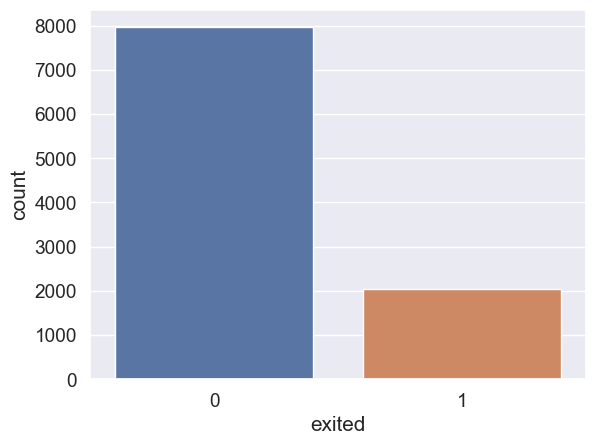

0    7963
1    2037
Name: exited, dtype: int64


In [42]:
sns.countplot(data=churn_df, x='exited')
plt.show()
print(churn_df.exited.value_counts())

* Observation:
* The target variable or column shows imbalanced values. Bank customers who are willing to stay are 7963 while those who left the bank are 2037.

## Data Prepration for ML

In [43]:
churn_df.head()

creditscore   age  tenure    balance  numofproducts  hascrcard  \
0          619  42.0     2.0       0.00              1          1   
1          608  41.0     1.0   83807.86              1          0   
2          502  42.0     8.0  159660.80              3          1   
3          699  39.0     1.0       0.00              2          0   
4          850  43.0     2.0  125510.82              1          1   

   isactivemember  estimatedsalary  exited  geography_France  \
0               1        101348.88       1                 1   
1               1        112542.58       0                 0   
2               0        113931.57       1                 1   
3               0         93826.63       0                 1   
4               1         79084.10       0                 0   

   geography_Germany  geography_Spain  gender_Female  gender_Male  
0                  0                0              1            0  
1                  0                1              1            0  
2                  0                0              1            0  
3                  0                0              1            0  
4                  0                1              1            0

In [44]:
churn_df.describe()

creditscore           age        tenure        balance  numofproducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.905700      4.543400   76485.889288       1.530200   
std       96.653299     10.449427      3.111573   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      2.000000       0.000000       1.000000   
50%      652.000000     37.000000      4.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     85.000000     10.000000  250898.090000       4.000000   

         hascrcard  isactivemember  estimatedsalary        exited  \
count  10000.00000    10000.000000     10000.000000  10000.000000   
mean       0.70550        0.515100    100090.239881      0.203700   
std        0.45584        0.499797     57510.492818      0.402769   
min        0.00000        0.000000        11.580000      0.000000   
25%        0.00000        0.000000     51002.110000      0.000000   
50%        1.00000        1.000000    100193.915000      0.000000   
75%        1.00000        1.000000    149388.247500      0.000000   
max        1.00000        1.000000    199992.480000      1.000000   

       geography_France  geography_Germany  geography_Spain  gender_Female  \
count      10000.000000       10000.000000     10000.000000   10000.000000   
mean           0.501400           0.250900         0.247700       0.454300   
std            0.500023           0.433553         0.431698       0.497932   
min            0.000000           0.000000         0.000000       0.000000   
25%            0.000000           0.000000         0.000000       0.000000   
50%            1.000000           0.000000         0.000000       0.000000   
75%            1.000000           1.000000         0.000000       1.000000   
max            1.000000           1.000000         1.000000       1.000000   

        gender_Male  
count  10000.000000  
mean       0.545700  
std        0.497932  
min        0.000000  
25%        0.000000  
50%        1.000000  
75%        1.000000  
max        1.000000

### Applying Normalization

In [45]:
transformer = MinMaxScaler()
def scaling(columns):
    return transformer.fit_transform(churn_df[columns].values.reshape(-1,1))

columns_to_be_scaled = ['creditscore', 'age', 'balance', 'estimatedsalary']
for i in columns_to_be_scaled:
    churn_df[i] = scaling(i)
    
churn_df.head()

creditscore       age  tenure   balance  numofproducts  hascrcard  \
0        0.538  0.358209     2.0  0.000000              1          1   
1        0.516  0.343284     1.0  0.334031              1          0   
2        0.304  0.358209     8.0  0.636357              3          1   
3        0.698  0.313433     1.0  0.000000              2          0   
4        1.000  0.373134     2.0  0.500246              1          1   

   isactivemember  estimatedsalary  exited  geography_France  \
0               1         0.506735       1                 1   
1               1         0.562709       0                 0   
2               0         0.569654       1                 1   
3               0         0.469120       0                 1   
4               1         0.395400       0                 0   

   geography_Germany  geography_Spain  gender_Female  gender_Male  
0                  0                0              1            0  
1                  0                1              1            0  
2                  0                0              1            0  
3                  0                0              1            0  
4                  0                1              1            0

In [46]:
churn_df2 = churn_df.copy()

In [47]:
features = churn_df.drop('exited', axis=1)
target = churn_df.exited

### Splitting the Dataset

In [48]:
train_size=0.6

features_train, features_rem, target_train, target_rem = train_test_split(features,target, train_size=0.6)

test_size = 0.2
features_valid, features_test, target_valid, target_test = train_test_split(features_rem,target_rem, test_size=0.2)

print(features_train.shape), print(target_train.shape)
print(features_valid.shape), print(target_valid.shape)
print(features_test.shape), print(target_test.shape)

(6000, 13)
(6000,)
(3200, 13)
(3200,)
(800, 13)
(800,)


(None, None)

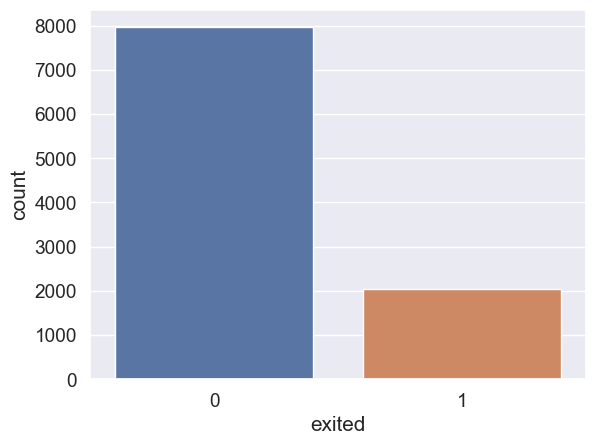

0    7963
1    2037
Name: exited, dtype: int64


In [49]:
sns.countplot(data=churn_df, x='exited')
plt.show()
print(churn_df.exited.value_counts())

## Machine Learning Models

In [50]:
features_train

creditscore       age  tenure   balance  numofproducts  hascrcard  \
3071        0.896  0.208955     7.0  0.000000              2          0   
4658        0.700  0.149254     8.0  0.637312              1          0   
8080        0.814  0.432836     3.0  0.521116              1          1   
1134        0.838  0.134328     2.0  0.000000              1          1   
1751        0.382  0.164179     7.0  0.508193              1          0   
...           ...       ...     ...       ...            ...        ...   
142         0.664  0.373134     5.0  0.501606              1          1   
9551        0.688  0.194030     4.0  0.565924              2          1   
3474        0.740  0.223881     6.0  0.387363              1          0   
479         0.616  0.164179     4.0  0.319901              1          1   
2784        0.942  0.283582     5.0  0.424290              2          0   

      isactivemember  estimatedsalary  geography_France  geography_Germany  \
3071               1         0.188620                 1                  0   
4658               0         0.113446                 0                  0   
8080               0         0.719158                 1                  0   
1134               1         0.289350                 1                  0   
1751               0         0.430853                 1                  0   
...              ...              ...               ...                ...   
142                1         0.966626                 1                  0   
9551               0         0.130539                 0                  1   
3474               0         0.459392                 0                  0   
479                1         0.103016                 1                  0   
2784               1         0.637068                 0                  1   

      geography_Spain  gender_Female  gender_Male  
3071                0              0            1  
4658                1              0            1  
8080                0              0            1  
1134                0              1            0  
1751                0              0            1  
...               ...            ...          ...  
142                 0              1            0  
9551                0              0            1  
3474                1              0            1  
479                 0              0            1  
2784                0              1            0  

[6000 rows x 13 columns]

In [51]:
target_train

3071    0
4658    0
8080    0
1134    0
1751    0
       ..
142     0
9551    0
3474    0
479     0
2784    0
Name: exited, Length: 6000, dtype: int64

* Observations:
* The columns except 'exited' was assigned as variable X.
* The column 'exited' was assigned as variable y. It contains the data we would like to predict. 
* The training  data will use 75% for actual training purposes and once training is completed, we will use the remaining 25% of the training data to check the training accuracy of our trained  model.

## Train and build baseline model

### Decision Tree

In [52]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(features_train, target_train)
y_pred = clf.predict(features_test)

#### Decision Tree Accuracy Scores

In [53]:
acc = round(accuracy_score(target_test,y_pred), 3)
f1 = round(f1_score(target_test,y_pred), 3)
rec = round(recall_score(target_test,y_pred), 3)
prec = round(precision_score(target_test,y_pred), 3)

dt_results = pd.DataFrame([['Decision Tree', acc, f1, rec, prec]],
                          columns = ['Model', 'Accuracy Score', 'F1 Score', 'Recall Score', 'Precision Score'])

dt_results

Model  Accuracy Score  F1 Score  Recall Score  Precision Score
0  Decision Tree           0.816     0.269         0.167            0.692

#### Decision Tree Confusion Matrix

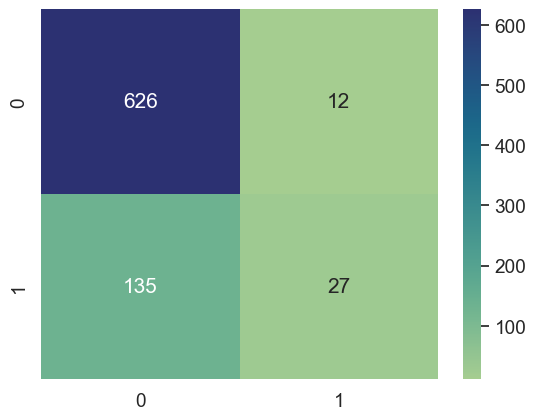

In [54]:
cm = confusion_matrix(target_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f", cmap="crest")
plt.show()

#### Evaluation Metrics

In [55]:
#Cross-Validation
accuracies = cross_val_score(estimator=clf, X=features_train, y=target_train, cv=10)
print(f'Accuracy Score is:', format(accuracies.mean()*100)) 

Accuracy Score is: 84.48333333333335


In [56]:
#Hyperparameter Tuning
for depth in [1, 2, 4, 6, 8, None]:
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth)

        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        probablities_valid = model.predict_proba(features_valid)[:, 1]

        print("max_depth =", depth)
        print('  F1 =', f1_score(target_valid, predicted_valid))
        print('  AUC-ROC =', roc_auc_score(target_valid, probablities_valid))

max_depth = 1
  F1 = 0.0
  AUC-ROC = 0.6962957043354755
max_depth = 2
  F1 = 0.5196850393700787
  AUC-ROC = 0.7490657589760612
max_depth = 4
  F1 = 0.41828571428571426
  AUC-ROC = 0.8152149412992784
max_depth = 6
  F1 = 0.5289421157684631
  AUC-ROC = 0.8240114140454349
max_depth = 8
  F1 = 0.579372197309417
  AUC-ROC = 0.8256416156002884
max_depth = None
  F1 = 0.5110602593440122
  AUC-ROC = 0.6881602111387641


In [57]:
#grid_search = GridSearchCV(estimator=dt,param_grid=params,cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")
#grid_search.fit(X_train, y_train)
#print(grid_search.best_params_)
#print(grid_search.best_score_)

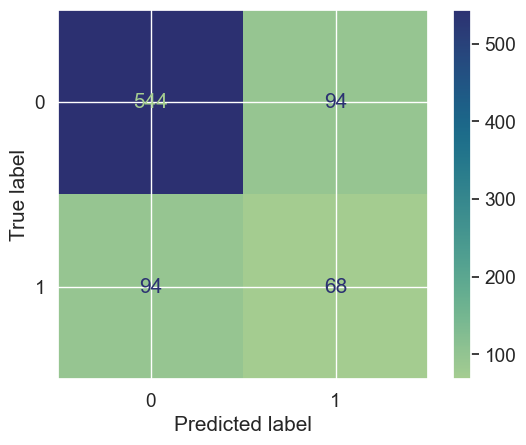

In [58]:
ConfusionMatrixDisplay.from_predictions(target_test, model.predict(features_test), cmap="crest")
plt.show()

### RandomForest

In [59]:
rf = RandomForestClassifier()
rf.fit(features_train,target_train)
y_pred_rf = rf.predict(features_test)

#### Random Forest Accuracy Scores

In [60]:
acc = round(accuracy_score(target_test,y_pred_rf), 3)
f1 = round(f1_score(target_test,y_pred_rf), 3)
rec = round(recall_score(target_test,y_pred_rf), 3)
prec = round(precision_score(target_test,y_pred_rf), 3)

rf_results = pd.DataFrame([['Random Forest Classifier', acc, f1, rec, prec]],
                          columns = ['Model', 'Accuracy Score', 'F1 Score', 'Recall Score', 'Precision Score'])

rf_results

Model  Accuracy Score  F1 Score  Recall Score  \
0  Random Forest Classifier            0.85      0.52         0.401   

   Precision Score  
0            0.739

#### Random Forest Confusion Matrix

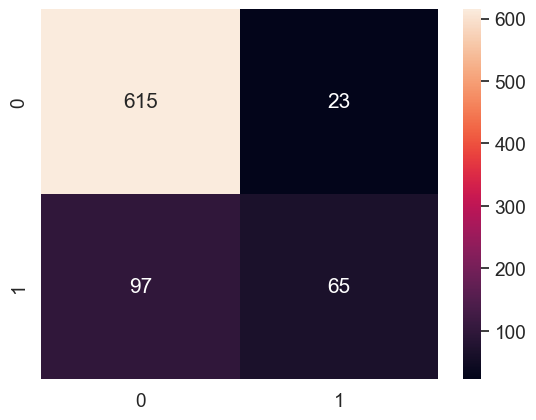

In [61]:
cm1 = confusion_matrix(target_test, y_pred_rf)
sns.heatmap(cm1, annot=True, fmt=".0f", cmap="rocket")
plt.show()

#### Evaluation Metrics

In [62]:
#Cross-Validation
accuracies = cross_val_score(estimator=rf, X=features_train, y=target_train, cv=10)
print(f'Accuracy Score is:', format(accuracies.mean()*100)) 

Accuracy Score is: 86.16666666666667


In [63]:
##Hyperparameter Tuning
for estim in range(10, 101, 10):
    model = RandomForestClassifier(random_state=12345, n_estimators=estim)

    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    probablities_valid = model.predict_proba(features_valid)[:, 1]

    print("n_estimators =", estim)
    print('  F1 =', f1_score(target_valid, predicted_valid))
    print('  AUC-ROC =', roc_auc_score(target_valid, probablities_valid))

n_estimators = 10
  F1 = 0.527536231884058
  AUC-ROC = 0.8032268564948413
n_estimators = 20
  F1 = 0.5538461538461539
  AUC-ROC = 0.8297995223851936
n_estimators = 30
  F1 = 0.5555555555555556
  AUC-ROC = 0.8394302695848124
n_estimators = 40
  F1 = 0.563758389261745
  AUC-ROC = 0.8428077638458822
n_estimators = 50
  F1 = 0.5670789724072312
  AUC-ROC = 0.8463685057588355
n_estimators = 60
  F1 = 0.5687022900763359
  AUC-ROC = 0.8496388616164081
n_estimators = 70
  F1 = 0.5678776290630975
  AUC-ROC = 0.8519859537454826
n_estimators = 80
  F1 = 0.5665071770334928
  AUC-ROC = 0.8526232223367765
n_estimators = 90
  F1 = 0.570884871550904
  AUC-ROC = 0.852011421070904
n_estimators = 100
  F1 = 0.568421052631579
  AUC-ROC = 0.8541582873311473


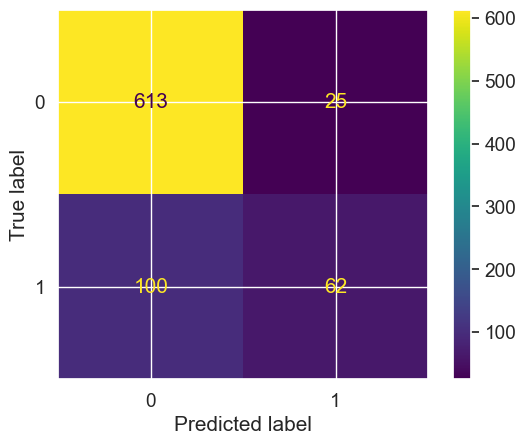

In [64]:
ConfusionMatrixDisplay.from_predictions(target_test, model.predict(features_test))
plt.show()

### Logistic Regression

In [65]:
lr = LogisticRegression()
lr.fit(features_train, target_train)
y_pred_lr = lr.predict(features_test)

#### Logistic Regression Accuracy Forest

In [66]:
acc = round(accuracy_score(target_test,y_pred_lr), 3)
f1 = round(f1_score(target_test,y_pred_lr), 3)
rec = round(recall_score(target_test,y_pred_lr), 3)
prec = round(precision_score(target_test,y_pred_lr), 3)

lr_results = pd.DataFrame([['Logistic Regrssion', acc, f1, rec, prec]],
                          columns = ['Model', 'Accuracy Score', 'F1 Score', 'Recall Score', 'Precision Score'])

lr_results

Model  Accuracy Score  F1 Score  Recall Score  Precision Score
0  Logistic Regrssion           0.808       0.3         0.204            0.569

#### Logistic Regression Confusion Matrix

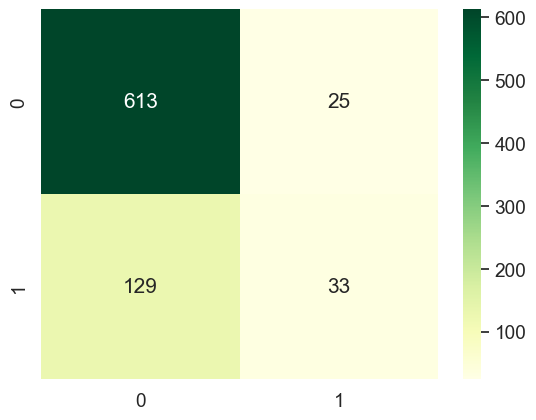

In [67]:
cm2 = confusion_matrix(target_test, y_pred_lr)
sns.heatmap(cm2, annot=True, fmt=".0f", cmap="YlGn")
plt.show()

#### Evaluation Metrics

In [68]:
#Cross-Validation
accuracies = cross_val_score(estimator=lr, X=features_train, y=target_train, cv=10)
print(f'Accuracy Score is:', format(accuracies.mean()*100)) 

Accuracy Score is: 81.43333333333332


In [69]:
#params = {'C' : np.logspace(-3, 3, 7),'penalty' : ('l2', 'l1')}
#gridsearch_lr = GridSearchCV(LogisticRegression(solver='liblinear'), params, cv=5)gridsearch_lr.fit(X_train, y_train)
#print(gridsearch_lr.best_params_)
#print(gridsearch_lr.best_score_)

In [70]:
#Hyperparameter Tuning
model_lr = LogisticRegression(random_state=12345)
    
model_lr.fit(features_train, target_train)
predicted_valid = model_lr.predict(features_valid)
probablities_valid = model_lr.predict_proba(features_valid)[:, 1]

print('F1 =', f1_score(target_valid, predicted_valid))
print('AUC-ROC =', roc_auc_score(target_valid, probablities_valid))

F1 = 0.327796234772979
AUC-ROC = 0.7628693420823842


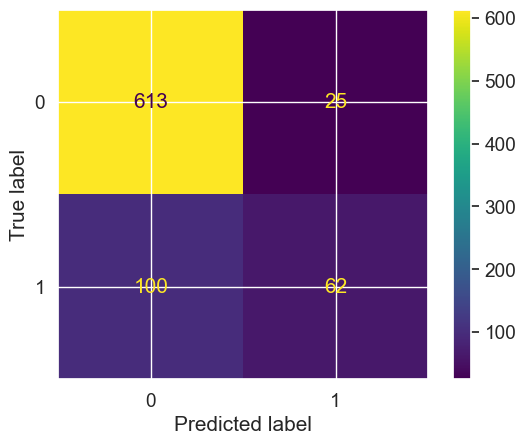

In [71]:
ConfusionMatrixDisplay.from_predictions(target_test, model.predict(features_test))
plt.show()

## Summary of Models Accuracy Scores

In [72]:
dt_results1 = dt_results.append(rf_results, ignore_index=True)
dt_results1 = dt_results1.append(lr_results, ignore_index=True)
dt_results1

Model  Accuracy Score  F1 Score  Recall Score  \
0             Decision Tree           0.816     0.269         0.167   
1  Random Forest Classifier           0.850     0.520         0.401   
2        Logistic Regrssion           0.808     0.300         0.204   

   Precision Score  
0            0.692  
1            0.739  
2            0.569

## Fixing the Imbalanced Dataset

### Using the Class weight balanced Approach

#### Logistic Regression

In [73]:
model_lr = LogisticRegression(random_state=12345)
    
model_lr.fit(features_train, target_train)
predicted_valid = model_lr.predict(features_valid)
probablities_valid = model_lr.predict_proba(features_valid)[:, 1]

print('F1 =', f1_score(target_valid, predicted_valid))
print('AUC-ROC =', roc_auc_score(target_valid, probablities_valid))

F1 = 0.327796234772979
AUC-ROC = 0.7628693420823842


#### Decision Tree with hyperparameter tuning

In [74]:
for depth in [1, 2, 4, 6, 8, None]:
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')

    model_dt.fit(features_train, target_train)
    predicted_valid = model_dt.predict(features_valid)
    probablities_valid = model_dt.predict_proba(features_valid)[:, 1]

print("max_depth =", depth)
print('  F1 =', f1_score(target_valid, predicted_valid))
print('  AUC-ROC =', roc_auc_score(target_valid, probablities_valid))

max_depth = None
  F1 = 0.5247678018575851
  AUC-ROC = 0.6956724866823453


#### Random Forest with hyperparameter tuning

In [75]:
## Random Forest with hyperparameter tuning
for estim in range(10, 101, 10):
    model_rf = RandomForestClassifier(random_state=12345, n_estimators=estim, class_weight='balanced')

    model_rf.fit(features_train, target_train)
    predicted_valid = model_rf.predict(features_valid)
    probablities_valid = model_rf.predict_proba(features_valid)[:, 1]

print("n_estimators =", estim)
print('  F1 =', f1_score(target_valid, predicted_valid))
print('  AUC-ROC =', roc_auc_score(target_valid, probablities_valid))

n_estimators = 100
  F1 = 0.5708775313404051
  AUC-ROC = 0.8549521653373893


### Using the Upsampling Approach

In [76]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

In [77]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

#### Logistic Regression

In [78]:
model_lr1 = LogisticRegression(random_state=12345)

model_lr1.fit(features_upsampled, target_upsampled)
predicted_valid = model_lr1.predict(features_valid)
probablities_valid = model_lr1.predict_proba(features_valid)[:, 1]

print('F1 =', f1_score(target_valid, predicted_valid))
print('AUC-ROC =', roc_auc_score(target_valid, probablities_valid))

F1 = 0.5094816687737043
AUC-ROC = 0.767012612473369


#### Decision Tree with Hyperparameter Tuning

In [79]:
for depth in [1, 2, 4, 6, 8, None]:
    model_dt1 = DecisionTreeClassifier(random_state=12345, max_depth=depth)

    model_dt1.fit(features_upsampled, target_upsampled)
    predicted_valid = model_dt1.predict(features_valid)
    probablities_valid = model_dt1.predict_proba(features_valid)[:, 1]

print("max_depth =", depth)
print('  F1 =', f1_score(target_valid, predicted_valid))
print('  AUC-ROC =', roc_auc_score(target_valid, probablities_valid))

max_depth = None
  F1 = 0.5252830188679245
  AUC-ROC = 0.6975632160489816


#### Random Forest with Hyperparameter Tuning

In [80]:
for estim in range(10, 101, 10):
    model_rf1 = RandomForestClassifier(random_state=12345, n_estimators=estim)

    model_rf1.fit(features_upsampled, target_upsampled)
    predicted_valid = model_rf1.predict(features_valid)
    probablities_valid = model_rf1.predict_proba(features_valid)[:, 1]

print("n_estimators =", estim)
print('  F1 =', f1_score(target_valid, predicted_valid))
print('  AUC-ROC =', roc_auc_score(target_valid, probablities_valid))

n_estimators = 100
  F1 = 0.6151231945624469
  AUC-ROC = 0.8484334082131246


### Using Downsampling Approach

In [81]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

In [82]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

#### Logistic Regression

In [83]:
model_lr2 = LogisticRegression(random_state=12345)
    
model_lr2.fit(features_downsampled, target_downsampled)
predicted_valid = model_lr2.predict(features_valid)
probablities_valid = model_lr2.predict_proba(features_valid)[:, 1]

print('F1 =', f1_score(target_valid, predicted_valid))
print('AUC-ROC =', roc_auc_score(target_valid, probablities_valid))

F1 = 0.5115180153573539
AUC-ROC = 0.7678609378649951


#### Decision Tree with Hyperparameter Tuning

In [84]:
for depth in [1, 2, 4, 6, 8, None]:
    model_dt2 = DecisionTreeClassifier(random_state=12345, max_depth=depth)

    model_dt2.fit(features_downsampled, target_downsampled)
    predicted_valid = model_dt2.predict(features_valid)
    probablities_valid = model_dt2.predict_proba(features_valid)[:, 1]

print("max_depth =", depth)
print('  F1 =', f1_score(target_valid, predicted_valid))
print('  AUC-ROC =', roc_auc_score(target_valid, probablities_valid))

max_depth = None
  F1 = 0.5090114691425451
  AUC-ROC = 0.7078198154526363


#### Random Forest with Hyperparameter Tuning

In [85]:
for estim in range(10, 101, 10):
    model_rf2 = RandomForestClassifier(random_state=12345, n_estimators=estim)

    model_rf2.fit(features_downsampled, target_downsampled)
    predicted_valid = model_rf2.predict(features_valid)
    probablities_valid = model_rf2.predict_proba(features_valid)[:, 1]

    print("n_estimators =", estim)
    print('  F1 =', f1_score(target_valid, predicted_valid))
    print('  AUC-ROC =', roc_auc_score(target_valid, probablities_valid))

n_estimators = 10
  F1 = 0.5641693811074918
  AUC-ROC = 0.8180353744077384
n_estimators = 20
  F1 = 0.6068875893437298
  AUC-ROC = 0.8443633197917417
n_estimators = 30
  F1 = 0.6092544987146529
  AUC-ROC = 0.8484064772483112
n_estimators = 40
  F1 = 0.6128205128205128
  AUC-ROC = 0.8511666084138189
n_estimators = 50
  F1 = 0.6140012845215158
  AUC-ROC = 0.8518852553553101
n_estimators = 60
  F1 = 0.6150919467343057
  AUC-ROC = 0.8525643840332164
n_estimators = 70
  F1 = 0.6194125159642401
  AUC-ROC = 0.8524718820236395
n_estimators = 80
  F1 = 0.6160657811511702
  AUC-ROC = 0.8542745002988752
n_estimators = 90
  F1 = 0.619257394587791
  AUC-ROC = 0.8540774944367068
n_estimators = 100
  F1 = 0.6159648020113137
  AUC-ROC = 0.8544123751296053


## Model Assessment

### Choosing Upsampling Approach

In [86]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

model_rf1 = RandomForestClassifier(random_state=12345, n_estimators=300)
model_rf1.fit(features_upsampled, target_upsampled)
    
predicted_test = model_rf1.predict(features_test)
probablities_test = model_rf1.predict_proba(features_test)[:, 1]

print('F1 =', f1_score(target_test, predicted_test))
print('AUC-ROC =', roc_auc_score(target_test, probablities_test)) 

F1 = 0.5428571428571428
AUC-ROC = 0.8288923719958203


* Observations:
* It was observed that upsampling and the Random Forest with n_estimator of 300 produced the best F1 score. 

## Conclusion

Using the dataset of Beta Bank, we are asked to build a model that predicts how likely a customer is going to churn. 

During the EDA or exploratory data analysis, we found out that the female customers are most likely to churn. Other observations with highest count of churn include customers living in Germany and using 1 product from the bank. 

After building and comparing several models, we decided on two models: Random Forest and Decision Tree classifiers with the accuracy score of 93% and 81% respectively compared to the others.

Going further with the Random Forest, we implemented a cross-validation and hyperparameter tuning to check if they are still accurate. As a result, we achieved about 56% accuracy score. Using random forest classifier and upsampled dataset since it's the most accurate model, we checked for accuracy for training and testing the model.  